# Mean Reversion Backtest 

In this project we'll be investigating a mean reversion strategy that makes trades based off a stock's 10-day simple moving average: 

- buying when Price * X < SMA
- selling when Price > SMA

where X is an arbitrary multiplier. We'll be investigating specifically which particular value of X is most profitable for a given stock, and comparing results across different stocks to see if there is an ideal multiplier in general. 


First, we start off by importing the necessary libraries, we'll be using yfinance, numpy, pandas, and matplotlib. 

In [92]:
import math
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

We'll be runing the strategy on AAPL, OPGN, SYBT, and TGT testing multipliers starting at 0.01 to 0.1 incrementing by 0.005. 

In [93]:
symbols = ["AAPL", "OPGN", "SYBT", "TGT"]
time_period = '3mo'
sma_length = 10

results = []
multipliers = np.arange(0.01, 0.1, 0.005)
fees = 0.01

In [94]:
# Gets stock data using yfinance, calculates SMA and saves in new column
def get_data(symbol):
    data = yf.download(symbol, period=time_period)
    data['SMA'] = data['Adj Close'].rolling(window=sma_length).mean()
    data['SMA2'] = data['Adj Close'].rolling(window=sma_length * 3).mean()
    df = pd.DataFrame(data)
    df.to_csv(f'{symbol}.csv', index=False)
    return data

# Determines if a potential trade meets a target profit percentage
def target_reached(price, open_price, fees, target):
    profit = ((price - open_price) - fees)
    if profit >= price * target:
        return True
    else:
        return False

# Checks if a short should be bough back by evaluating if the profit meets a target percentage
def short_check(price, open, fees, target):
    profit = (open - price) - fees
    if profit > (open * target):
        return True
    else:
        return False

# Checks if a stock is bearish by comparing a 30 day SMA to a 10 day SMA
def bearish(row):
    return row['SMA2'] > row['SMA']

In [95]:

def execute(data, x):
    # action dataframe keeps track of completed trades
    action = pd.DataFrame(columns=['Date', 'Type', 'Price'])

    profits = 0
    capital = 10000
    percent_of_capital = 0.10
    target = 0.01

    open_positions = pd.DataFrame(columns=['Type', 'Quantity', 'Open Price', 'Close Price', 'Profit'])

    for i, row in data.iterrows():
        price = row['Adj Close']
        sma = row['SMA']
        # cutoff variable represensts price * multiplier
        cutoff = price * (1 + x)
        # Buy
        if cutoff < sma:

            if not open_positions.empty and capital >= price:  # Check if there are open positions
                for j, position in open_positions.iterrows():

                    pos_type = position['Type']
                    open_price = position['Open Price']
                    quantity = position['Quantity']

                    # Buy back shorts
                    if pos_type == 'Short' and short_check(price, open_price, fees, target):
                        cost = (price * (1 + fees)) * quantity
                        capital -= cost
                        # Close position
                        profit = ((open_price - price) - fees) * quantity
                        profits += profit
                        open_positions.loc[j, 'Close Price'] = price
                        open_positions.loc[j, 'Profit'] = profit
                        open_positions.drop(j, inplace=True)

                        new_action = pd.DataFrame(
                            {'Date': [i], 'Type': ['Buy Back Short'], 'Price': [price]})
                        action = pd.concat([action, new_action], ignore_index=True)
            
            #Buy long
            if capital >= price:
                qty = math.ceil((capital * percent_of_capital) / price)
                cost = (price * (1 + fees)) * qty
                capital -= cost
                # Open a position
                new_row = pd.DataFrame(
                    {'Type': ['Long'], 'Quantity': [qty], 'Open Price': [price], 'Close Price': [0], 'Profit': [0]})
                open_positions = pd.concat([open_positions, new_row], ignore_index=True)

                new_action = pd.DataFrame(
                    {'Date': [i], 'Type': ['Buy'], 'Price': [price]})
                action = pd.concat([action, new_action], ignore_index=True)

        # Sell
        elif price > sma:

            if not open_positions.empty:
                for j, position in open_positions.iterrows():

                    pos_type = position['Type']
                    open_price = position['Open Price']
                    quantity = position['Quantity']

                    # Sell long
                    if pos_type == 'Long' and target_reached(price, open_price, fees, target):
                        revenue = (price * (1 - fees)) * quantity
                        capital += revenue

                        # Close the position
                        profit = ((price - open_price) - fees) * quantity
                        profits += profit
                        open_positions.loc[j, 'Close Price'] = price
                        open_positions.loc[j, 'Profit'] = profit
                        open_positions.drop(j, inplace=True)

                        new_action = pd.DataFrame(
                            {'Date': [i], 'Type': ['Sell'], 'Price': [price]})
                        action = pd.concat([action, new_action], ignore_index=True)

            # Short
            elif capital >= price and bearish(row):
                qty = math.ceil((capital * percent_of_capital) / price)
                revenue = (price * (1 - fees)) * qty
                capital += revenue

                # Open a position
                short = pd.DataFrame(
                    {'Type': ['Short'], 'Quantity': [qty], 'Open Price': [price], 'Close Price': [0], 'Profit': [0]})
                open_positions = pd.concat([open_positions, short], ignore_index=True)

                new_action = pd.DataFrame(
                    {'Date': [i], 'Type': ['Short'], 'Price': [price]})
                action = pd.concat([action, new_action], ignore_index=True)

    return [profits, action, open_positions]

In [96]:
# Organizes data for executed trades for a stock's most profitable multiplier
def record_trades(results, data, symbol): 
    index_max = np.argmax(results)
    most_profitable = multipliers[index_max]
    results = execute(data, most_profitable)
    actions = results[1]
    positions = results[2]

    print(f"{symbol}'s Most Profitable Multiplier: {most_profitable}")
    print(f"Open Positions:\n{positions}")

    buys = actions.loc[actions['Type'] == 'Buy']
    sells = actions.loc[actions['Type'] == 'Sell']
    shorts = actions.loc[actions['Type'] == 'Short']
    buy_backs = actions.loc[actions['Type'] == 'Buy Back Short']

    trade_data = [buys, sells, shorts, buy_backs]

    return trade_data

In [97]:
def plot(data, trades, results, symbol):
    buys = trades[0]
    sells = trades[1]
    shorts = trades[2]
    buy_backs = trades[3]

    fig, axs = plt.subplots(2, figsize=(10, 6))
    fig.suptitle(f'Mean Reversion for ${symbol}')

    axs[0].plot(data.index, data['Adj Close'], label="Close Prices")
    axs[0].plot(data.index, data['SMA'], label=f"{sma_length}-Day SMA")

    axs[0].scatter(buys['Date'], buys['Price'], label="Buy")
    axs[0].scatter(sells['Date'], sells['Price'], label="Sell")
    axs[0].scatter(shorts['Date'], shorts['Price'], label="Short")
    axs[0].scatter(buy_backs['Date'], buy_backs['Price'], label="Buy Back")
    axs[1].plot(multipliers, results)

    axs[0].set(xlabel='Date', ylabel='Price ($)')
    axs[1].set(xlabel='Multiplier', ylabel='PNL')

    axs[0].legend()
    plt.show()

[*********************100%***********************]  1 of 1 completed
AAPL's Most Profitable Multiplier: 0.015
Open Positions:
   Type Quantity  Open Price Close Price Profit
0  Long        8  136.500000           0      0
1  Long        7  134.509995           0      0
4  Long        5  135.449997           0      0


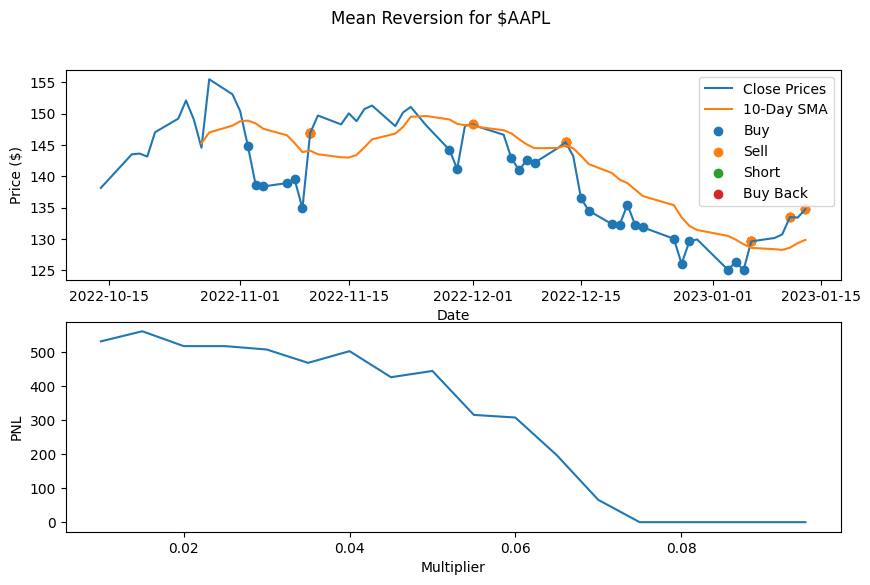

[*********************100%***********************]  1 of 1 completed
OPGN's Most Profitable Multiplier: 0.045
Open Positions:
   Type Quantity  Open Price Close Price Profit
0  Long      586        2.65           0      0
1  Long      602        2.32           0      0
2  Long      521        2.41           0      0
3  Long      489        2.31           0      0
4  Long      434        2.34           0      0


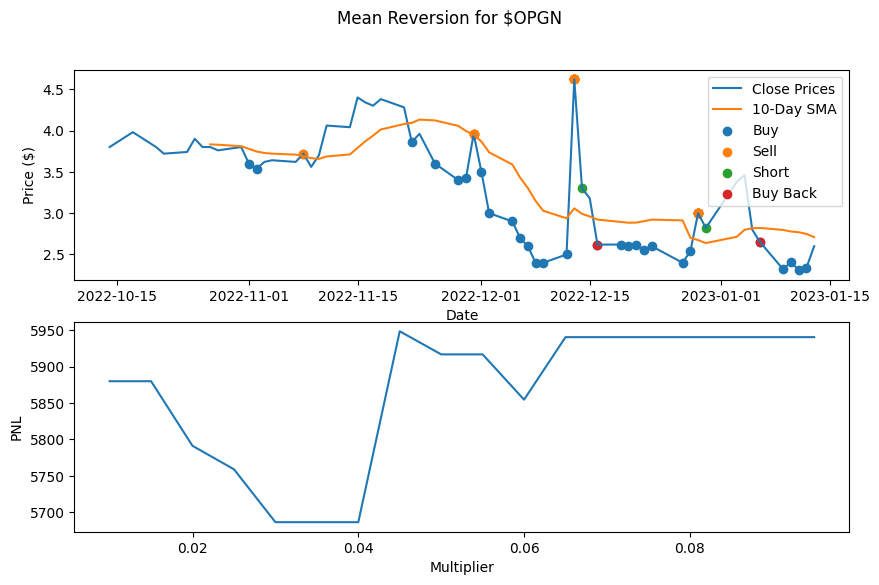

[*********************100%***********************]  1 of 1 completed
SYBT's Most Profitable Multiplier: 0.015
Open Positions:
   Type Quantity  Open Price Close Price Profit
0  Long       16   66.711449           0      0
1  Long        9   65.400002           0      0
2  Long       14   63.450001           0      0
3  Long       12   62.250000           0      0
4  Long       11   61.299999           0      0
5  Long       10   62.959999           0      0
6  Long        9   62.380001           0      0


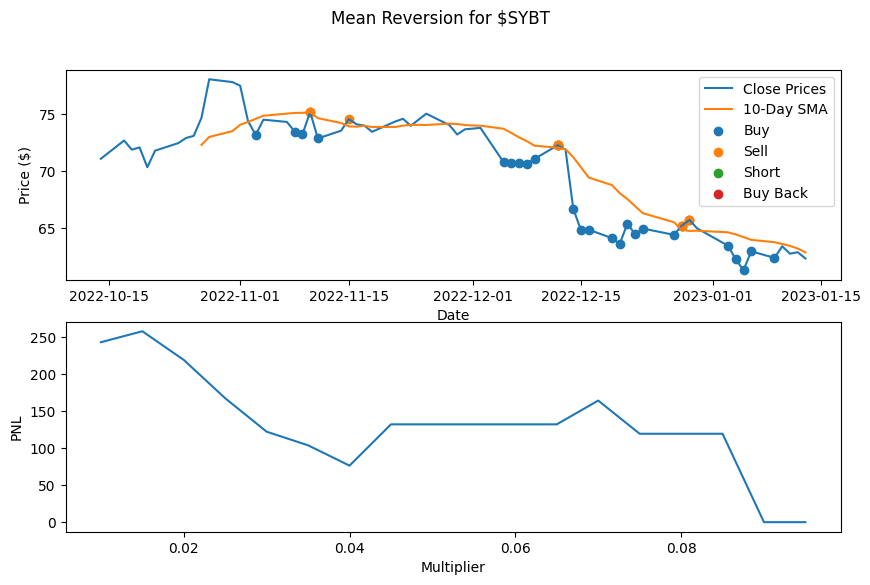

[*********************100%***********************]  1 of 1 completed
TGT's Most Profitable Multiplier: 0.01
Open Positions:
    Type Quantity  Open Price Close Price Profit
0  Short        7  156.350006           0      0


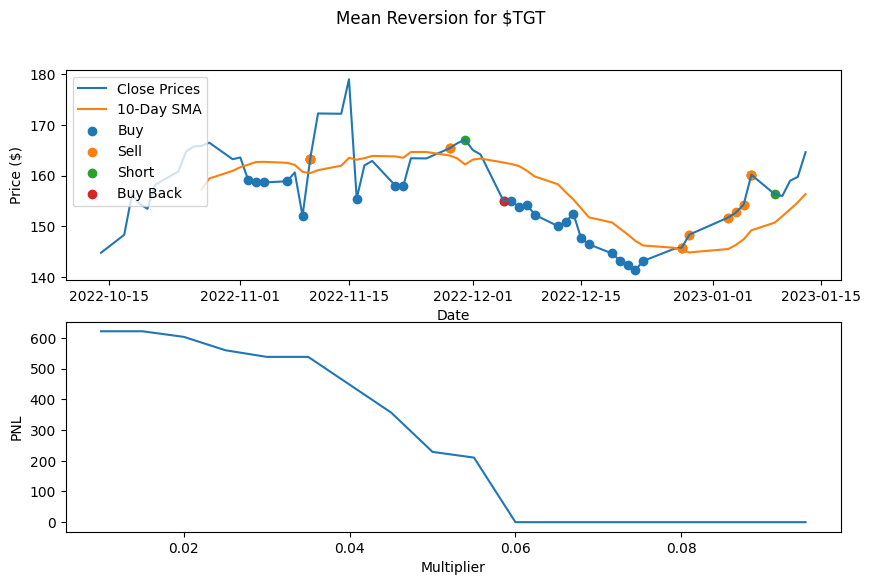

In [98]:

for symbol in symbols:
    pnl = []    
    data = get_data(symbol)
    for x in multipliers:
        results = execute(data, x)
        pnl.append(results[0])
    trades = record_trades(pnl, data, symbol)
    plot(data, trades, pnl, symbol)


# Conclusion

Our data yields the following as the most profitable multipliers: 

- AAPL: 0.015
- OPGN: 0.045
- SYBT: 0.015
- TGT: 0.010

We can see from the data that there is no relation between the most profitable multipliers of each stock, therefore a universal optimal-multiplier does not exist. Since the optimal multiplier varies across different stocks, the best practice would be to conduct specific backtests for specific financial instruments to determine what works best. 